# **Predict Employee Attrition: Transform**

## Objectives

* At the end of this phase, we will:
    - Import the dataset from Kaggle.
    - Check the data for missing and null values, and duplicates.
    - Analyze summary statistics.
    - Analyze correlation.
    - Explore further through visualizations.
    - State assumptions.
    - Summarize findings.

## Inputs

* [Task outline](https://docs.google.com/document/d/e/2PACX-1vThNllbMORJoc348kFavz4mZWT1-33xyazdD2L-3AlTfORlRhuDyT0xmCBQMD2C-K2djQQipt6te6lo/pub)
* Extract phase

## Outputs

* Overview of the dataset, its features, and how they are interacting.
* Basic visualizations that complement the overview.
* Summary of the findings and an overview of the next step.

## Additional Comments

* This dataset is synthetically created, as called out by the owner in Kaggle. For the current sprint, we will work with the available data. However, the dataset is biased and we will need to rectify this before building a prediction model. We will deal with bias in the next sprint.



---

# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pingouin as pg

---

# Data reupload

In [3]:
df = pd.read_csv("../data/cleaned_data/predict_employee_attrition_copy.csv")
print(df.shape)
df.head()

(1470, 32)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,3,4,1,6,3,3,2,2,2,2


---

# Data transformation

Aggregating satisfaction levels

In [4]:
# Create TotalSatisfaction feature by averaging satisfaction scores
satisfaction_cols = ["JobSatisfaction", "EnvironmentSatisfaction", "RelationshipSatisfaction", "WorkLifeBalance"]
df["TotalSatisfaction"] = df[satisfaction_cols].mean(axis=1)
print(df[["TotalSatisfaction"] + satisfaction_cols].head())

   TotalSatisfaction  JobSatisfaction  EnvironmentSatisfaction  \
0               2.00                4                        2   
1               3.00                2                        3   
2               3.00                3                        4   
3               3.25                3                        4   
4               2.50                2                        1   

   RelationshipSatisfaction  WorkLifeBalance  
0                         1                1  
1                         4                3  
2                         2                3  
3                         3                3  
4                         4                3  


In [5]:
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,TotalSatisfaction
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,1,0,8,0,1,6,4,0,5,2.00
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,4,1,10,3,3,10,7,1,7,3.00
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,2,0,7,3,3,0,0,0,0,3.00
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,3,0,8,3,3,8,7,3,0,3.25
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,4,1,6,3,3,2,2,2,2,2.50


In [10]:
print(df["Age"].nunique())
print("---" * 40)
print(df["Age"].unique())
print("---" * 40)
print(f"Min age: ", df["Age"].min())
print("---" * 40)
print(f"Max age: ", df["Age"].max())

43
------------------------------------------------------------------------------------------------------------------------
[41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]
------------------------------------------------------------------------------------------------------------------------
Min age:  18
------------------------------------------------------------------------------------------------------------------------
Max age:  60


In [11]:
# Define age brackets
bins = [18, 25, 35, 45, 55, 65]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65']

# Create AgeBracket column
df['AgeBracket'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True, include_lowest=True)

# Display the distribution of age brackets
print(df['AgeBracket'].value_counts())
print(df[['Age', 'AgeBracket']].head())

AgeBracket
26-35    606
36-45    468
46-55    226
18-25    123
56-65     47
Name: count, dtype: int64
   Age AgeBracket
0   41      36-45
1   49      46-55
2   37      36-45
3   33      26-35
4   27      26-35


In [12]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

In [13]:
df.head(6)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,TotalSatisfaction,AgeBracket
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,0,8,0,1,6,4,0,5,2.00,36-45
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,1,10,3,3,10,7,1,7,3.00,46-55
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,0,7,3,3,0,0,0,0,3.00,36-45
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,0,8,3,3,8,7,3,0,3.25,26-35
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,1,6,3,3,2,2,2,2,2.50,26-35
5,32,0,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,8,4,...,0,8,2,2,7,7,3,6,3.25,26-35


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   int64   
 1   Attrition                 1470 non-null   int64   
 2   BusinessTravel            1470 non-null   object  
 3   DailyRate                 1470 non-null   int64   
 4   Department                1470 non-null   object  
 5   DistanceFromHome          1470 non-null   int64   
 6   Education                 1470 non-null   int64   
 7   EducationField            1470 non-null   object  
 8   EmployeeNumber            1470 non-null   int64   
 9   EnvironmentSatisfaction   1470 non-null   int64   
 10  Gender                    1470 non-null   object  
 11  HourlyRate                1470 non-null   int64   
 12  JobInvolvement            1470 non-null   int64   
 13  JobLevel                  1470 non-null   int64 

In [16]:
(df == 0).sum()

Age                            0
Attrition                   1233
BusinessTravel                 0
DailyRate                      0
Department                     0
DistanceFromHome               0
Education                      0
EducationField                 0
EmployeeNumber                 0
EnvironmentSatisfaction        0
Gender                         0
HourlyRate                     0
JobInvolvement                 0
JobLevel                       0
JobRole                        0
JobSatisfaction                0
MaritalStatus                  0
MonthlyIncome                  0
MonthlyRate                    0
NumCompaniesWorked           197
OverTime                       0
PercentSalaryHike              0
PerformanceRating              0
RelationshipSatisfaction       0
StockOptionLevel             631
TotalWorkingYears             11
TrainingTimesLastYear         54
WorkLifeBalance                0
YearsAtCompany                44
YearsInCurrentRole           244
YearsSince

In [17]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
TotalSatisfaction           0
AgeBracket

---

# Correlation Analysis

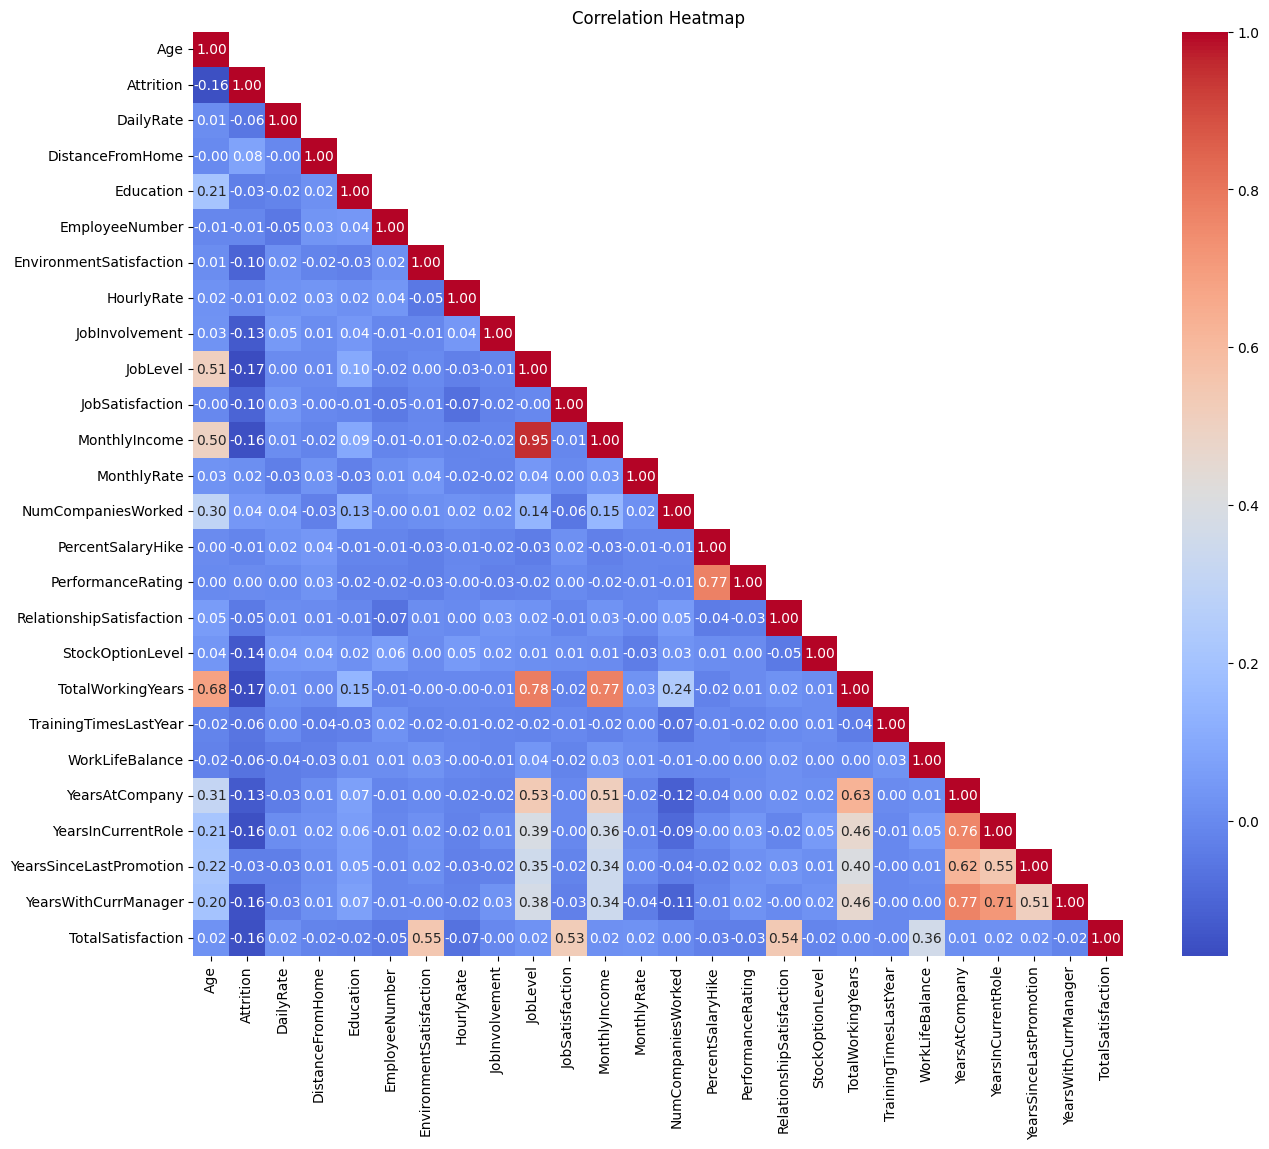

In [14]:
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(df.select_dtypes(include='number').corr(), dtype=bool), k=1)
sns.heatmap(df.select_dtypes(include='number').corr(), mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Correlation analysis:**
- The heatmap shows relationships between numerical features.
- Strong correlations may indicate redundancy or important relationships for modeling attrition.


In [ ]:
pd.crosstab(df['Attrition'], df['Gender'], normalize='columns')

Gender,Female,Male
Attrition,,
No,0.852041,0.829932
Yes,0.147959,0.170068


In [24]:
df = df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'], errors='ignore') #dropping columns that do not add value to the analysis
print(df.shape)
df.head(10)

(1470, 32)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,3,4,1,6,3,3,2,2,2,2
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,8,4,...,3,3,0,8,2,2,7,7,3,6
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,10,3,...,4,1,3,12,3,2,1,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,11,4,...,4,2,1,1,2,3,1,0,0,0
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,12,4,...,4,2,0,10,2,3,9,7,1,8
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,13,3,...,3,2,2,17,3,2,7,7,7,7


# Copy dataset

In [20]:
df.to_csv("../data/transformed_data/predict_employee_attrition_transformed.csv", index=False)

---

# Summary

- The employee attrition dataset is clean and ready for analysis.
- Categorical and numerical features have been explored for distribution, imbalance, and outliers.
- Correlation analysis provides insight into feature relationships.

**Next steps:**
- Explore potential for feature engineering.
- Perform statistical tests.


In [ ]:
# Create TotalSatisfaction feature by averaging satisfaction scores
satisfaction_cols = ["JobSatisfaction", "EnvironmentSatisfaction", "RelationshipSatisfaction", "WorkLifeBalance"]
df["TotalSatisfaction"] = df[satisfaction_cols].mean(axis=1)
print(df[["TotalSatisfaction"] + satisfaction_cols].head())